In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [91]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import SVHN
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_masked_batch_loss
from pathlib import Path
import inpainting.visualizations.samples as vis

In [4]:
from inpainting.datasets.svhn import train_val_datasets
from inpainting.visualizations.digits import rgb_with_mask 
from inpainting.training import train_inpainter
from inpainting.utils import classifier_experiment, inpainted
from inpainting.inpainters.rgb import RGBInpainter

In [5]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = "white"

In [6]:
# !ps aux | grep mprzewie 

In [7]:
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi


/bin/sh: 1: nvidia-smi: not found


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cpu')

In [9]:
experiment_path = Path("../results/svhn/tryout")
experiment_path.mkdir(exist_ok=True, parents=True)

Using downloaded and verified file: /home/mprzewie/uj/.data/train_32x32.mat
Using downloaded and verified file: /home/mprzewie/uj/.data/test_32x32.mat


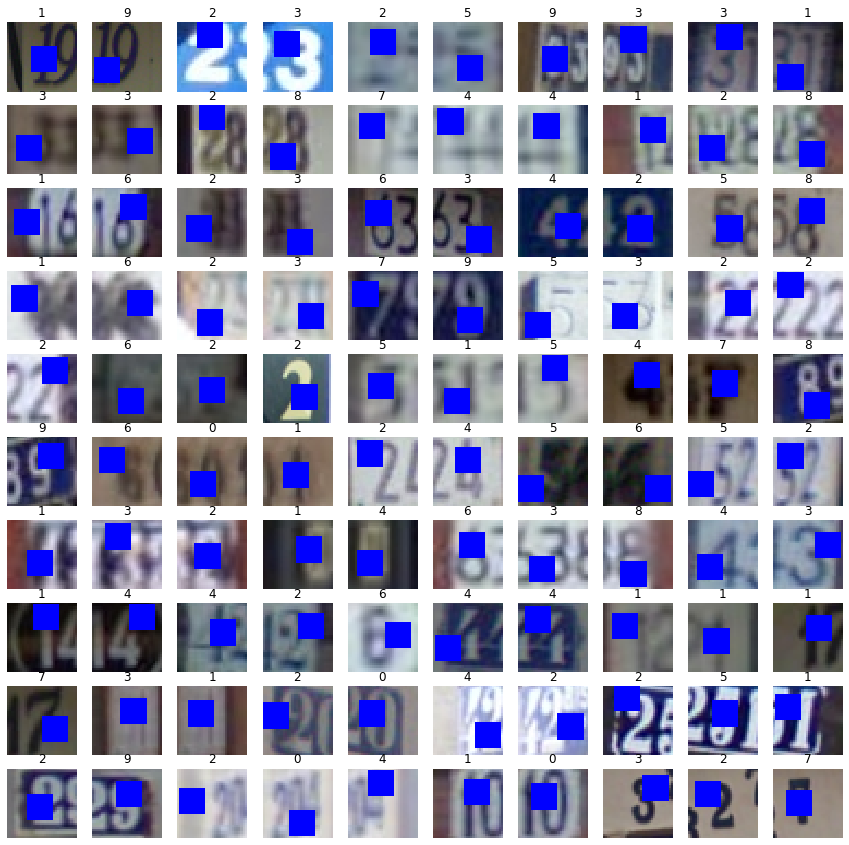

In [93]:
ds_train, ds_val = train_val_datasets(Path.home() / "uj/.data/")

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    (x,j), y = ds_train[i]
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y}")
    rgb_with_mask(x.numpy(), j.numpy(), ax)
train_fig = plt.gcf()
train_fig.savefig(experiment_path / "train.png")
plt.show()

In [11]:
# classifier = MLPClassifier((100, 200, 10,), learning_rate_init=4e-3, max_iter=1000).fit(ds_train.X.reshape(-1, 64), ds_train.y)

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler

In [19]:
batch_size=2
dl_train = DataLoader(ds_train, batch_size, sampler=SubsetRandomSampler(list(range(2))),)# shuffle=True)
dl_val = DataLoader(ds_val, batch_size, sampler=SubsetRandomSampler(list(range(2))),) # shuffle=True)

In [20]:
for (i,b) in enumerate(dl_train):
    print(i)

0


In [21]:
m_std = lambda x, j, p, m, a, d: m.std(dim=0).mean()

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
history = []
inpainter = RGBInpainter(n_mixes=1, last_channels=8)
opt = optim.Adam(inpainter.parameters(), lr=4e-5, weight_decay=0)
n_epochs = 1

In [24]:
for (x, j), y in dl_train:
    p, m, a, d = inpainter(x, j)

/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [25]:
p.shape, m.shape, a.shape, d.shape

(torch.Size([2, 1]),
 torch.Size([2, 1, 3072]),
 torch.Size([2, 1, 3, 3072]),
 torch.Size([2, 1, 3072]))

In [29]:
nll_masked_batch_loss(x, j, p, m, a, d)

torch.Size([2, 3072])
torch.Size([2])
torch.Size([2, 3072])
torch.Size([2, 3, 3072])
torch.Size([2, 3072])
torch.Size([2, 3072])
torch.Size([2, 1, 3072])
torch.Size([2, 3, 3072])
torch.Size([2, 3072, 3])
torch.Size([2, 3, 3072])
torch.Size([2, 3, 3])


tensor(273.7880, grad_fn=<DivBackward0>)

# Don't go beyond here

In [30]:
history = train_inpainter(
    inpainter, 
    dl_train, 
    dl_val, 
    opt, 
    loss_fn = nll_masked_batch_loss, 
    n_epochs=n_epochs,
    losses_to_log=None,
    device=device,
    history_start=history
#     tqdm_loader=True
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1 tensor(278.6620, grad_fn=<DivBackward0>)
2
3


100%|██████████| 1/1 [00:10<00:00, 10.82s/it]


In [64]:

with (experiment_path / "history_last_epoch.pkl").open("wb") as f:
    history_tmp = history
    pickle.dump(history[-1], f)

In [31]:
with (experiment_path / "inpainter.schema").open("w") as f:
    print(inpainter, file=f)
with (experiment_path / "opt.schema").open("w") as f:
    print(opt, file=f)

# torch.save(inpainter.state_dict, experiment_path / "inpainter.state")

In [32]:
[h["losses"] for h in history];

In [33]:
history[-1]["losses"]["objective"]

{'train': 282.98123, 'val': 339.29578}

In [34]:
history_tmp = history
history = history

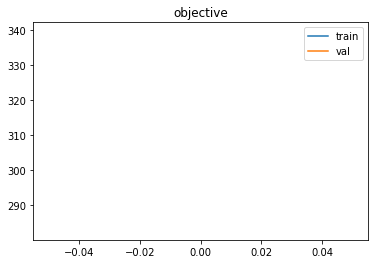

In [35]:
for loss_name in set(history[0]["losses"].keys()):
    for fold in ["train", "val"]:
        
        plt.plot(
            list(range(len(history))),
            [h["losses"][loss_name][fold] for h in history],
            label=fold
        )
    plt.title(loss_name)
    plt.legend()
    fig = plt.gcf()
    fig.savefig(experiment_path / f"history.{loss_name}.png")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

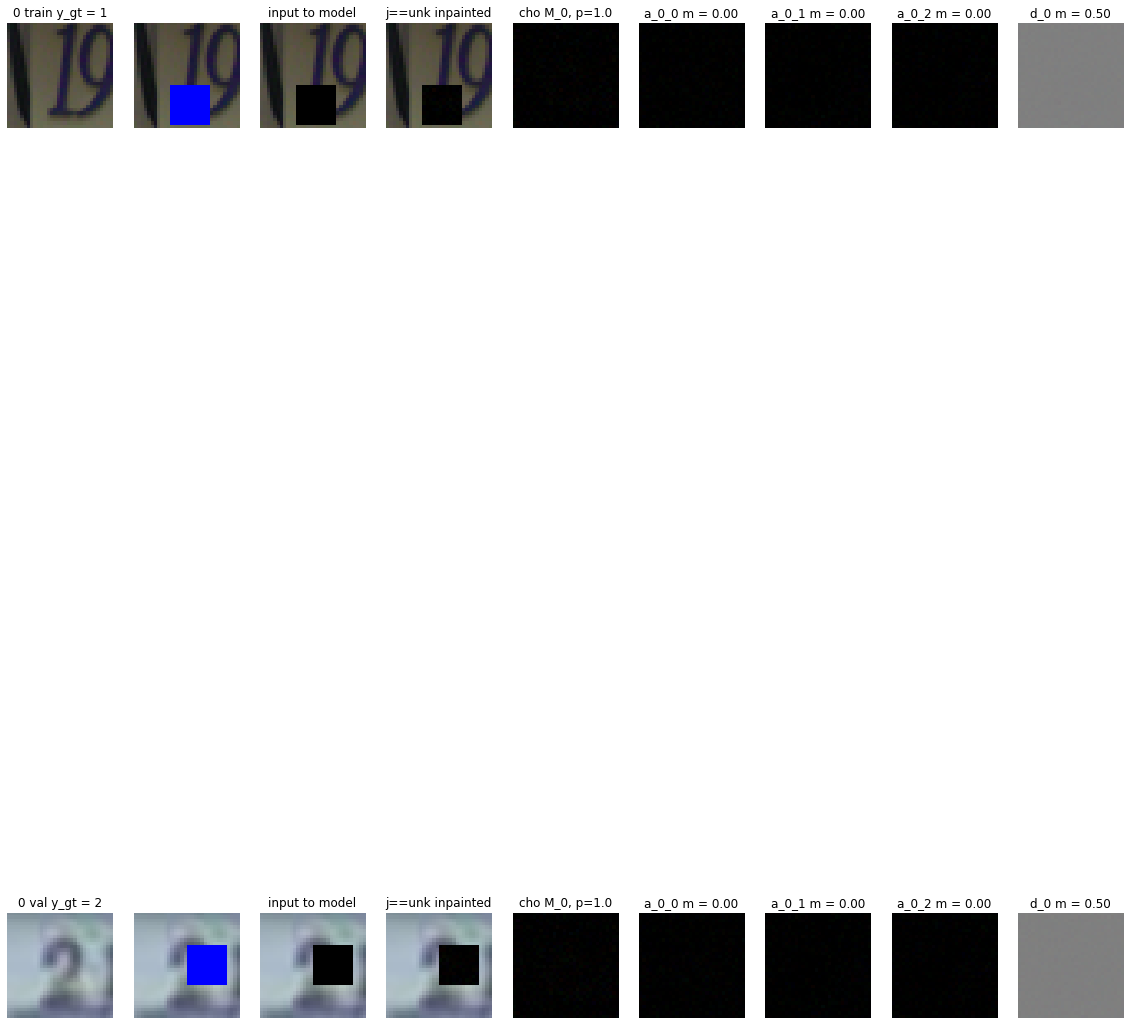

In [79]:
skip = 10

row_length = vis.row_length(*list(zip(*history[0]["sample_results"]["train"]))[0])
fig, axes = plt.subplots(
    int(np.ceil(len(history) / skip)* 2), 
    row_length,
    figsize=(20, 30)
)


for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        x, j, p, m, a, d, y = [t[0] for t in  h["sample_results"][fold]]
        row_no = (e // skip)*2 + ax_no

        vis.visualize_sample(
            x, j, p, m, a, d, y, 
            ax_row=axes[row_no], 
            title_prefixes={
                0: f"{e} {fold} ",
#                 1: f"y_m = {y_masked_pred}"
            },
            drawing_fn=rgb_with_mask
        )

epochs_fig = plt.gcf()
epochs_fig.savefig(experiment_path / "epochs_renders.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

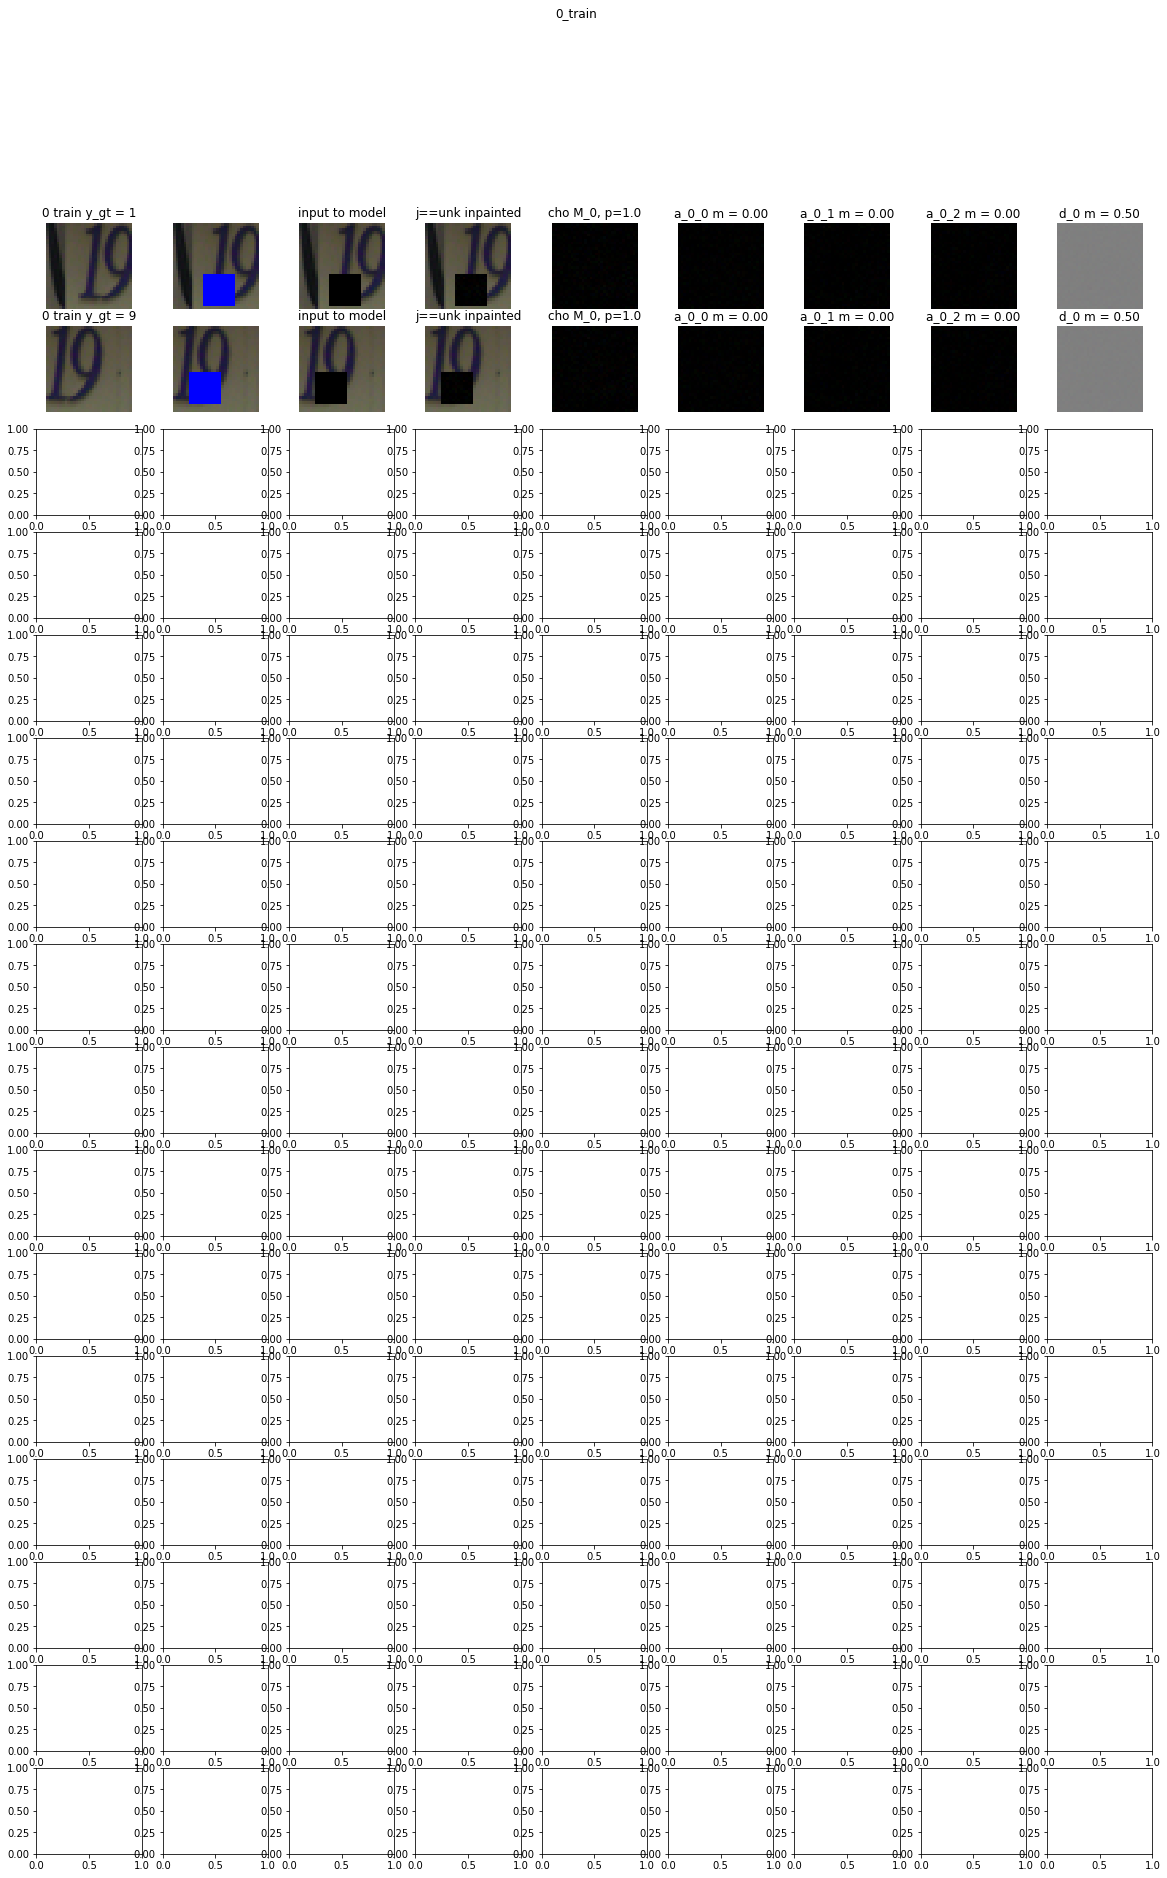

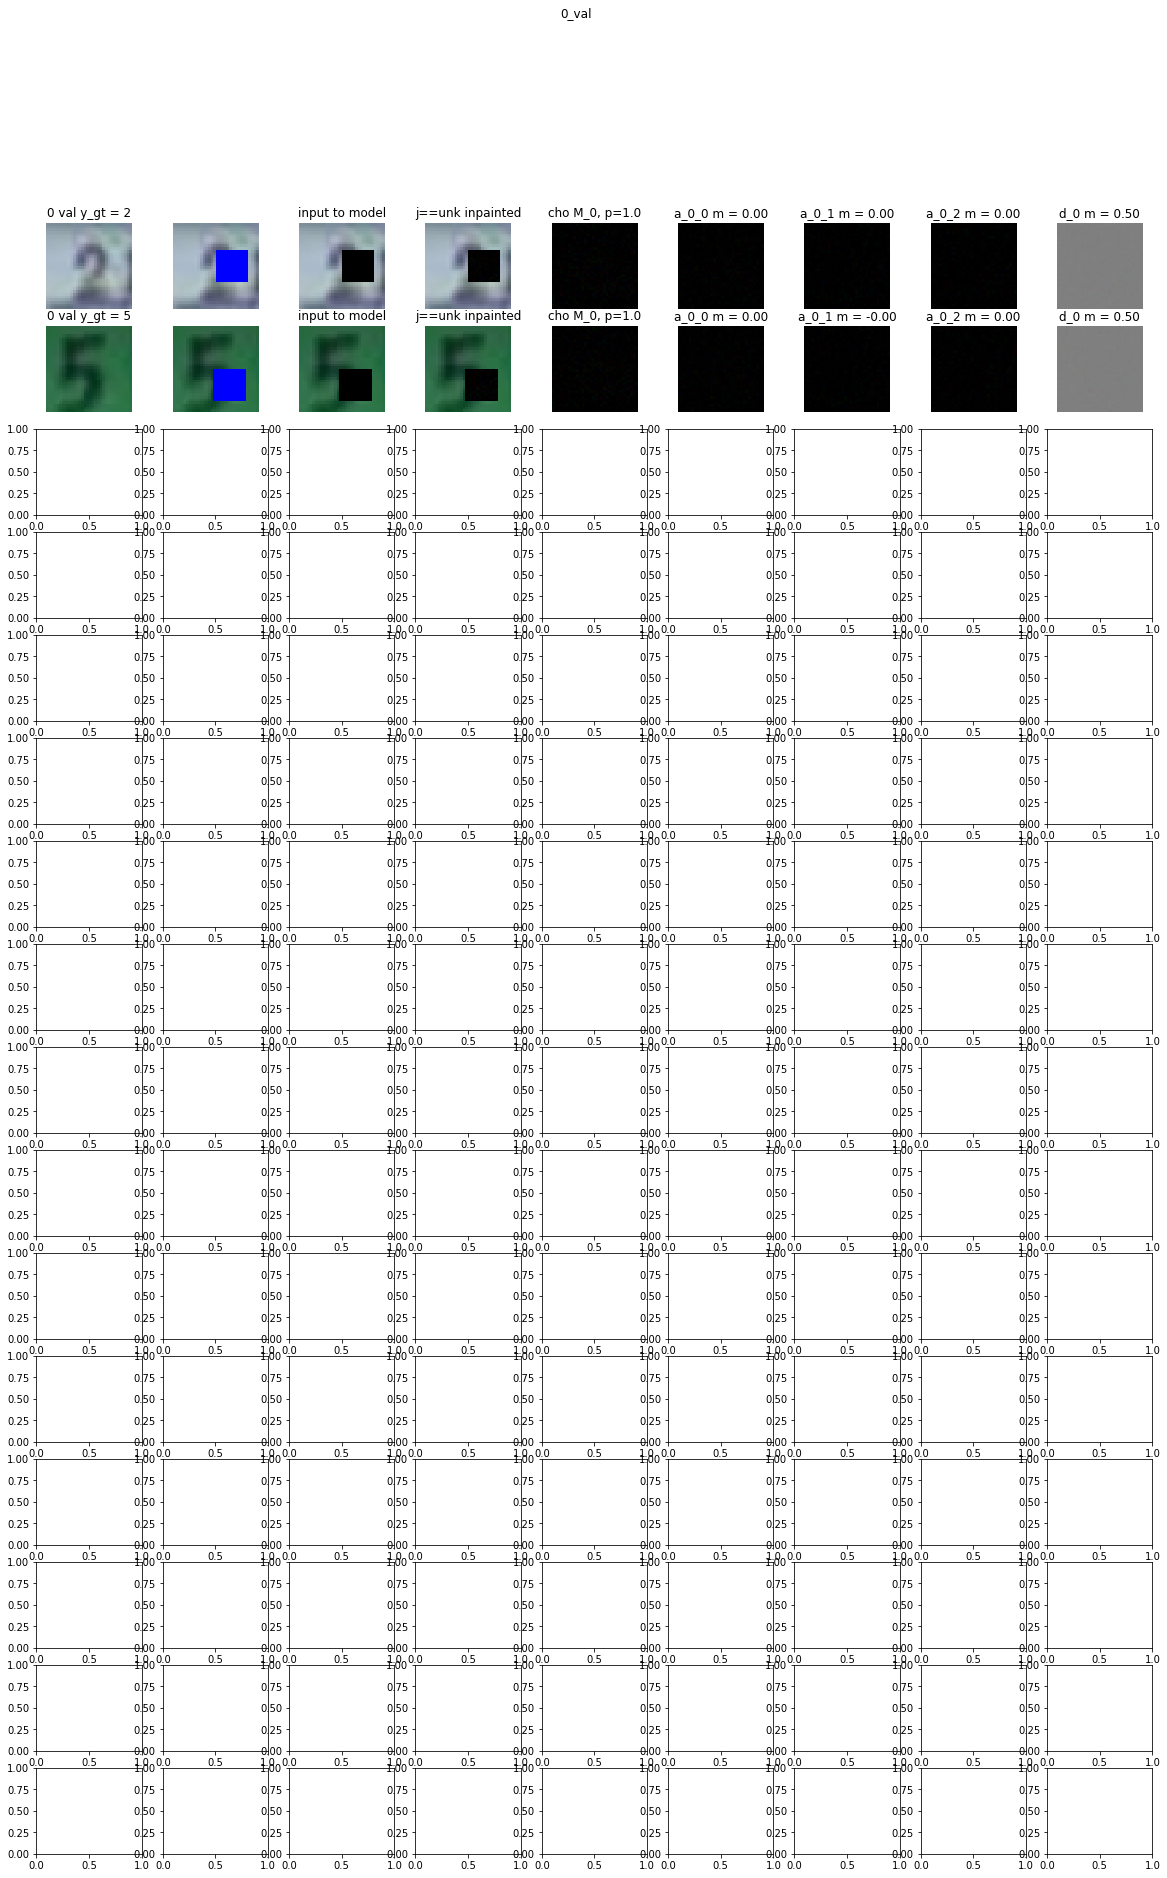

In [81]:
epochs_path = experiment_path / "epochs"
epochs_path.mkdir(exist_ok=True)
skip = 20
n_rows = 16

for e, h in enumerate(history):
    if e % skip !=0 and e != (len(history) -1):
        continue
    
    for ax_no, fold in [(0,"train"), (1,"val")]:
        
        
        row_length = vis.row_length(*list(zip(*h["sample_results"][fold]))[0])

        fig, axes = plt.subplots(
            n_rows, 
            row_length,
            figsize=(20, 30)
        )

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(*h["sample_results"][fold]))[:n_rows]):
            vis.visualize_sample(
                x, j, p, m, a, d, y, 
                ax_row=axes[row_no], 
                title_prefixes={
                    0: f"{e} {fold} ",
#                     1: f"y_m = {y_masked_pred}"
                },
                drawing_fn=rgb_with_mask
            )
        
        title = f"{e}_{fold}"
        plt.suptitle(title)
        plt.savefig(epochs_path / f"{title}.png")
#         plt.show()
            

# epochs_fig = plt.gcf()
# epochs_fig.savefig(experiment_path / "epochs_renders.png")

In [82]:
import pickle

with (experiment_path / "history_last_epoch.pkl").open("rb") as f:
    hist_last_epoch = pickle.load(f)

history = [hist_last_epoch]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

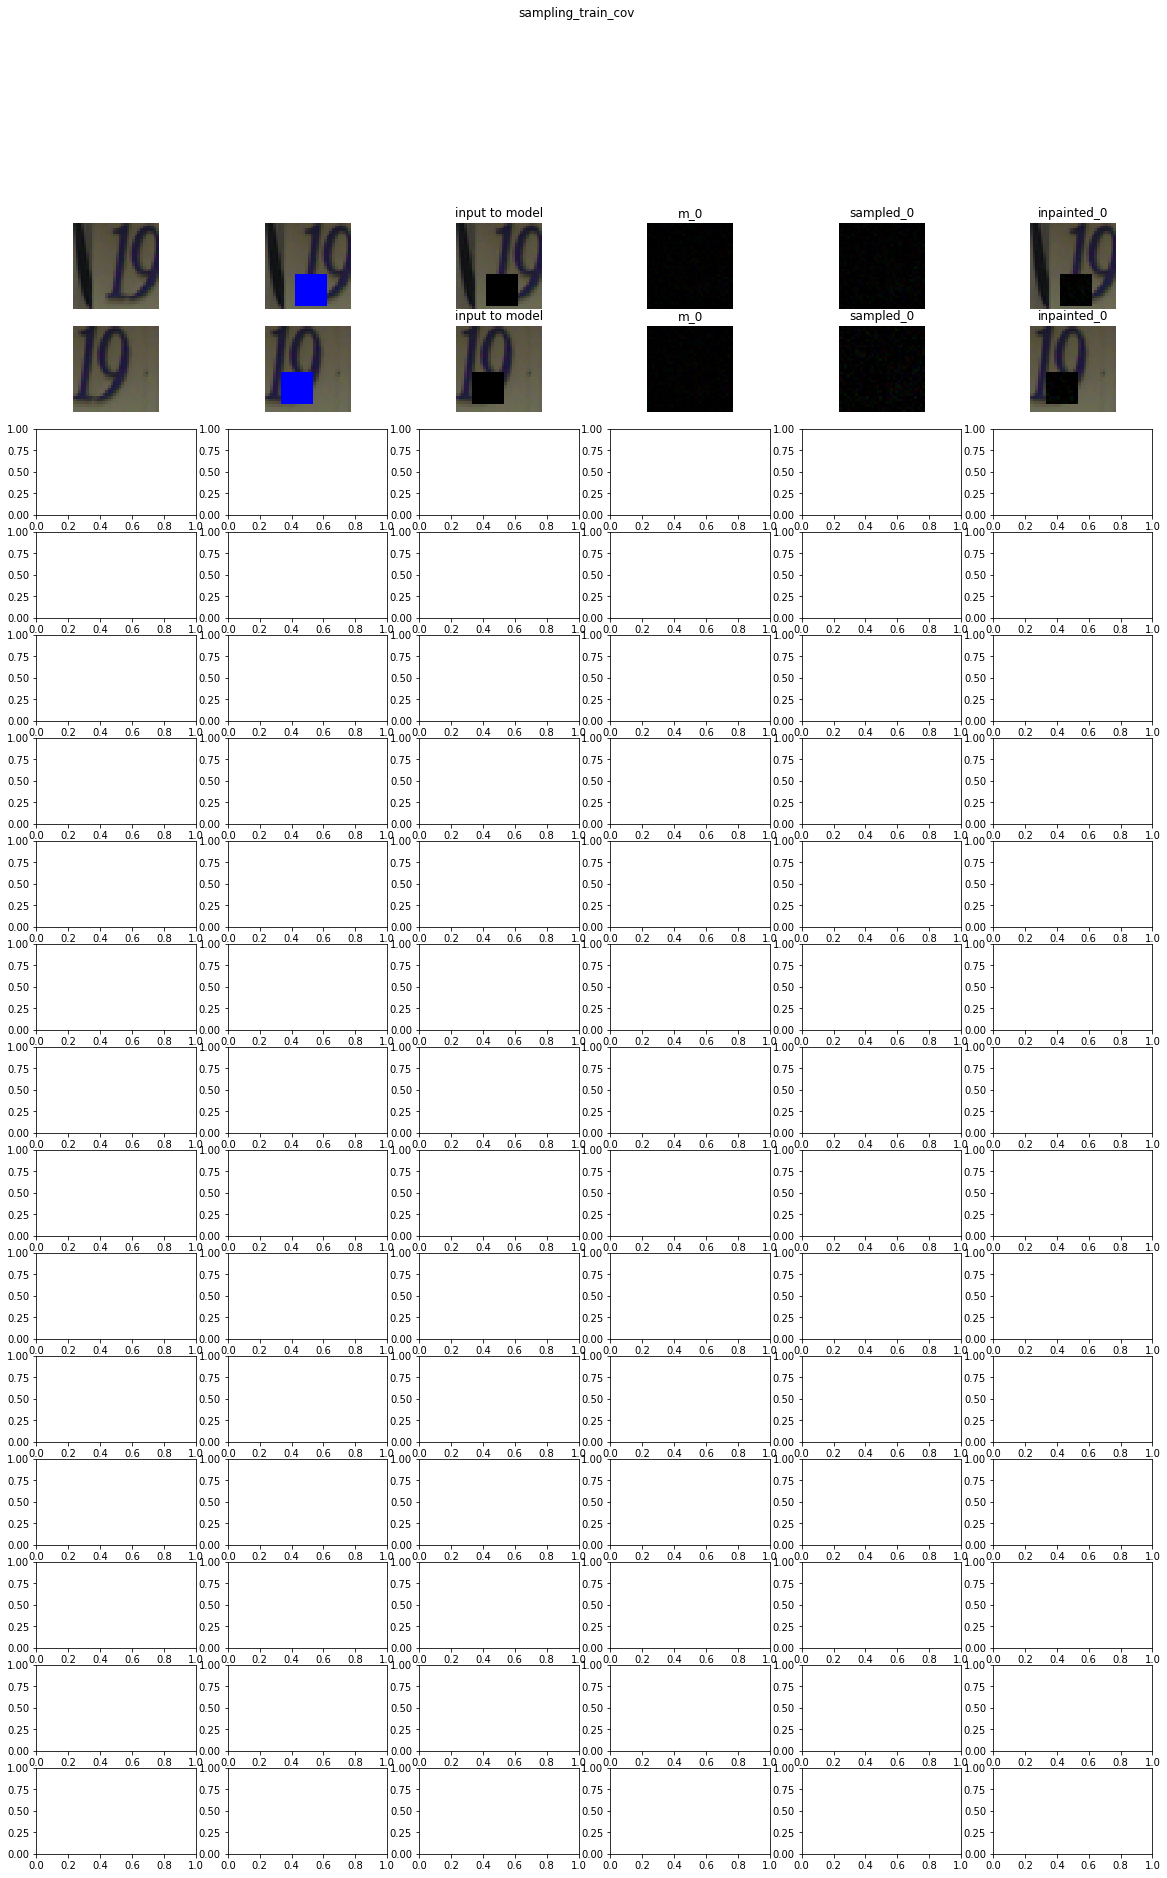

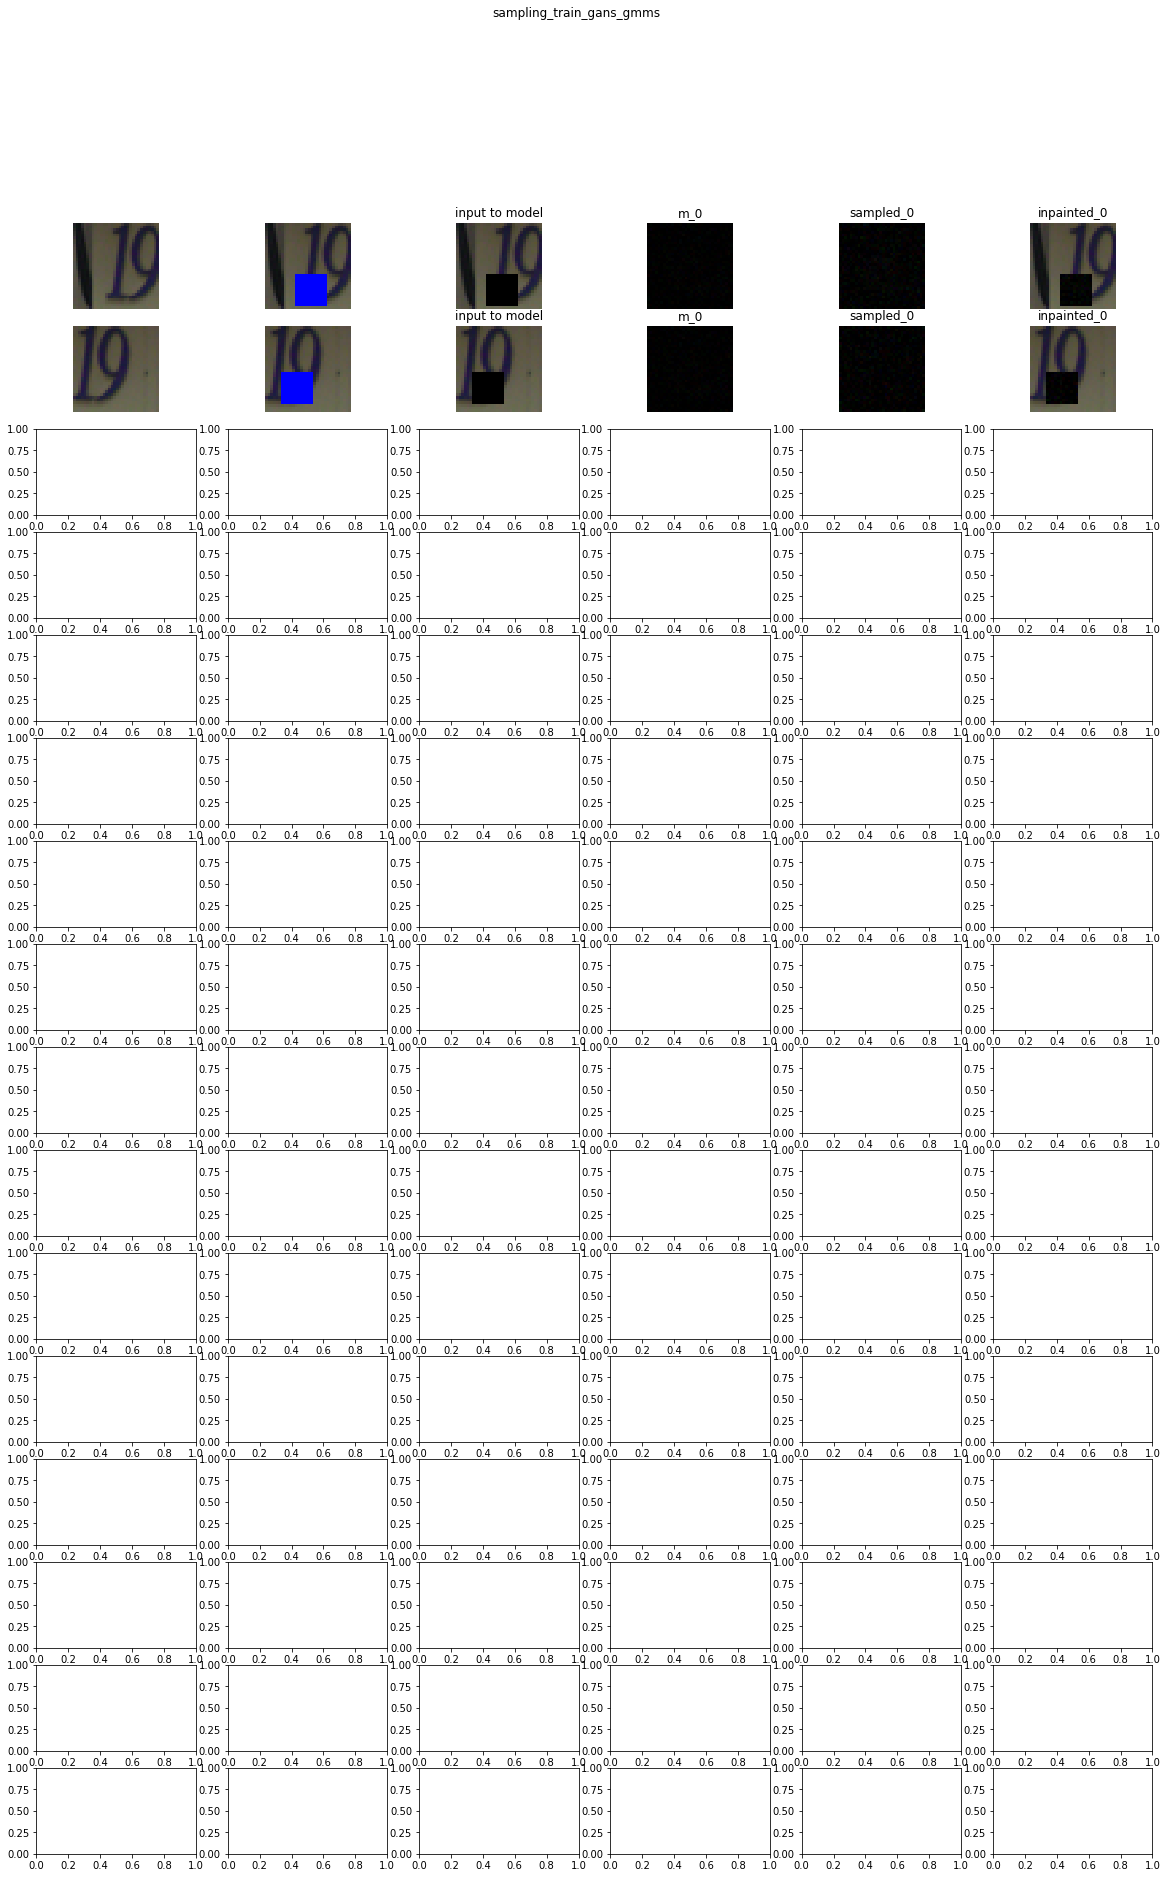

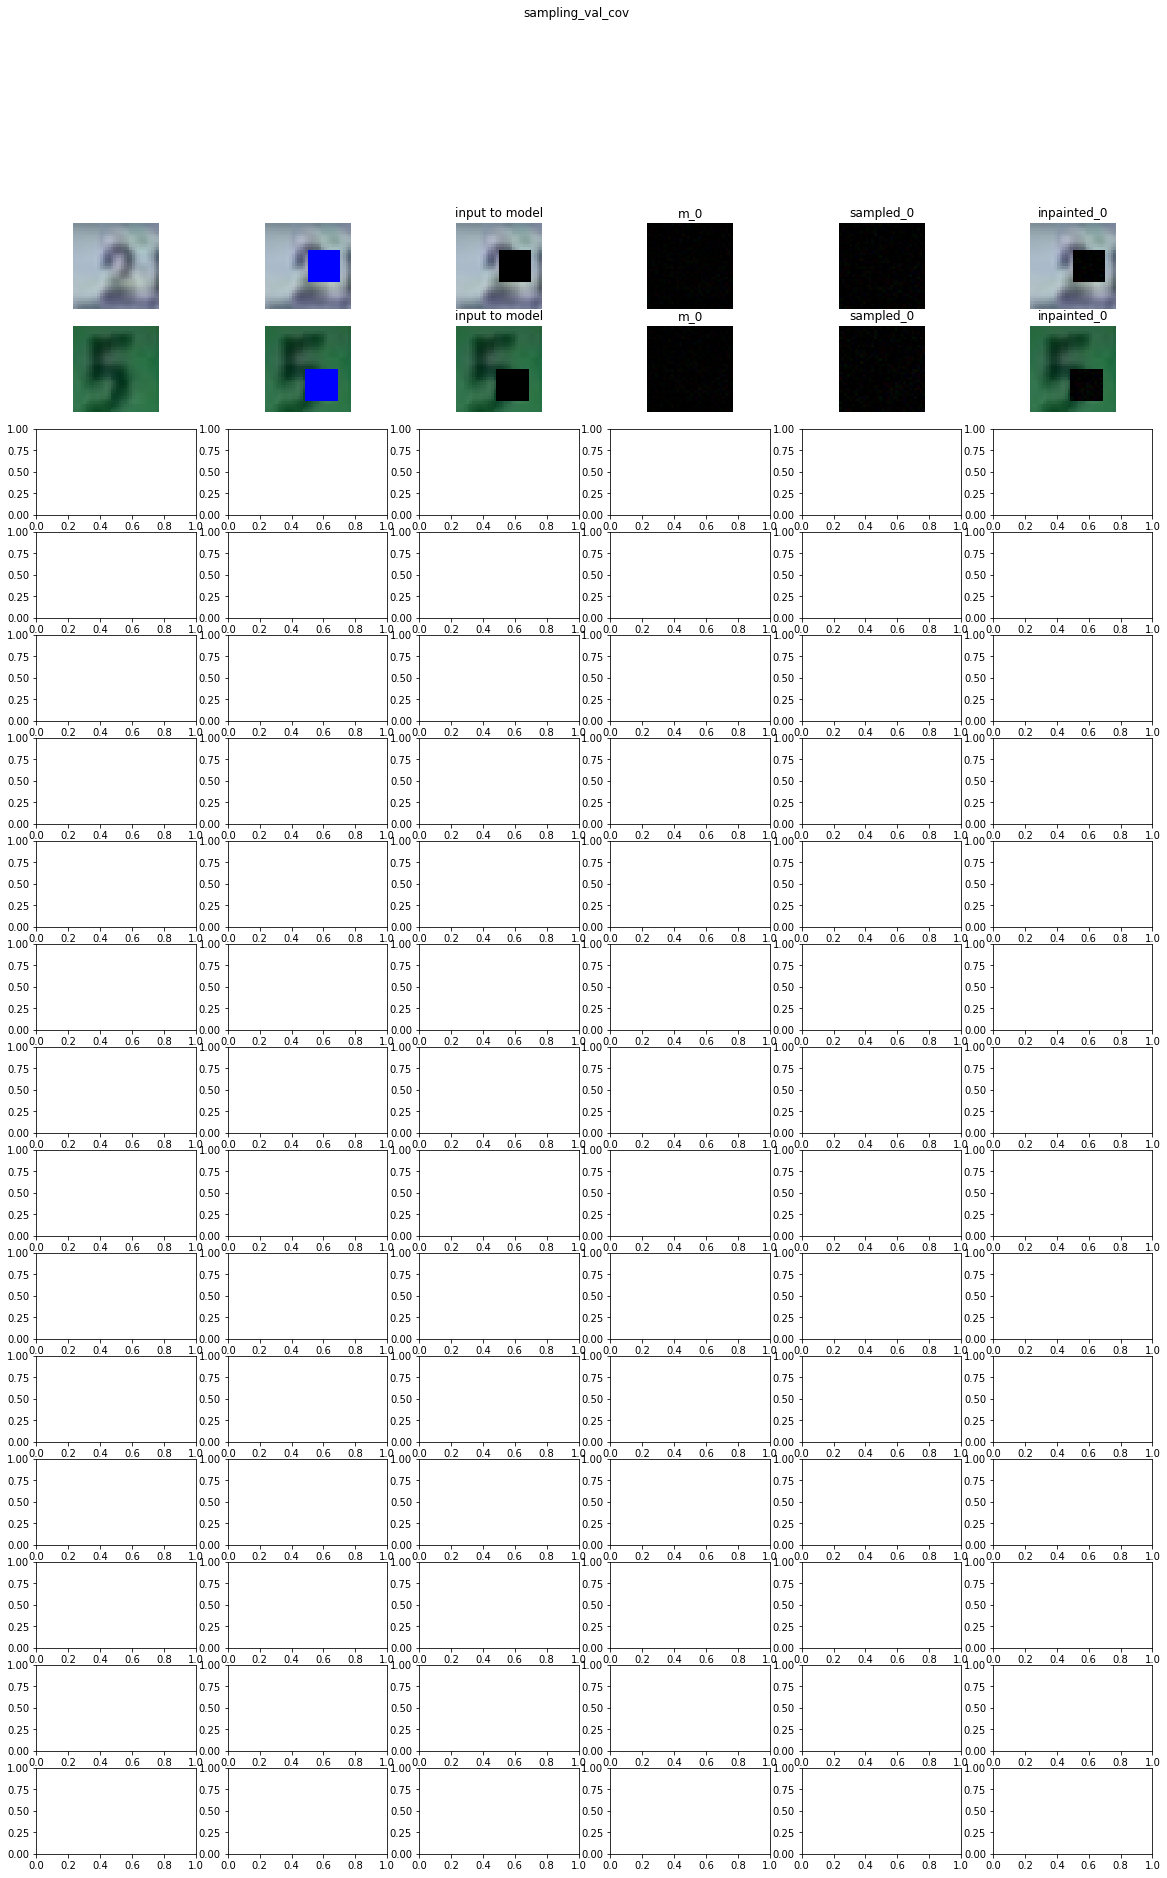

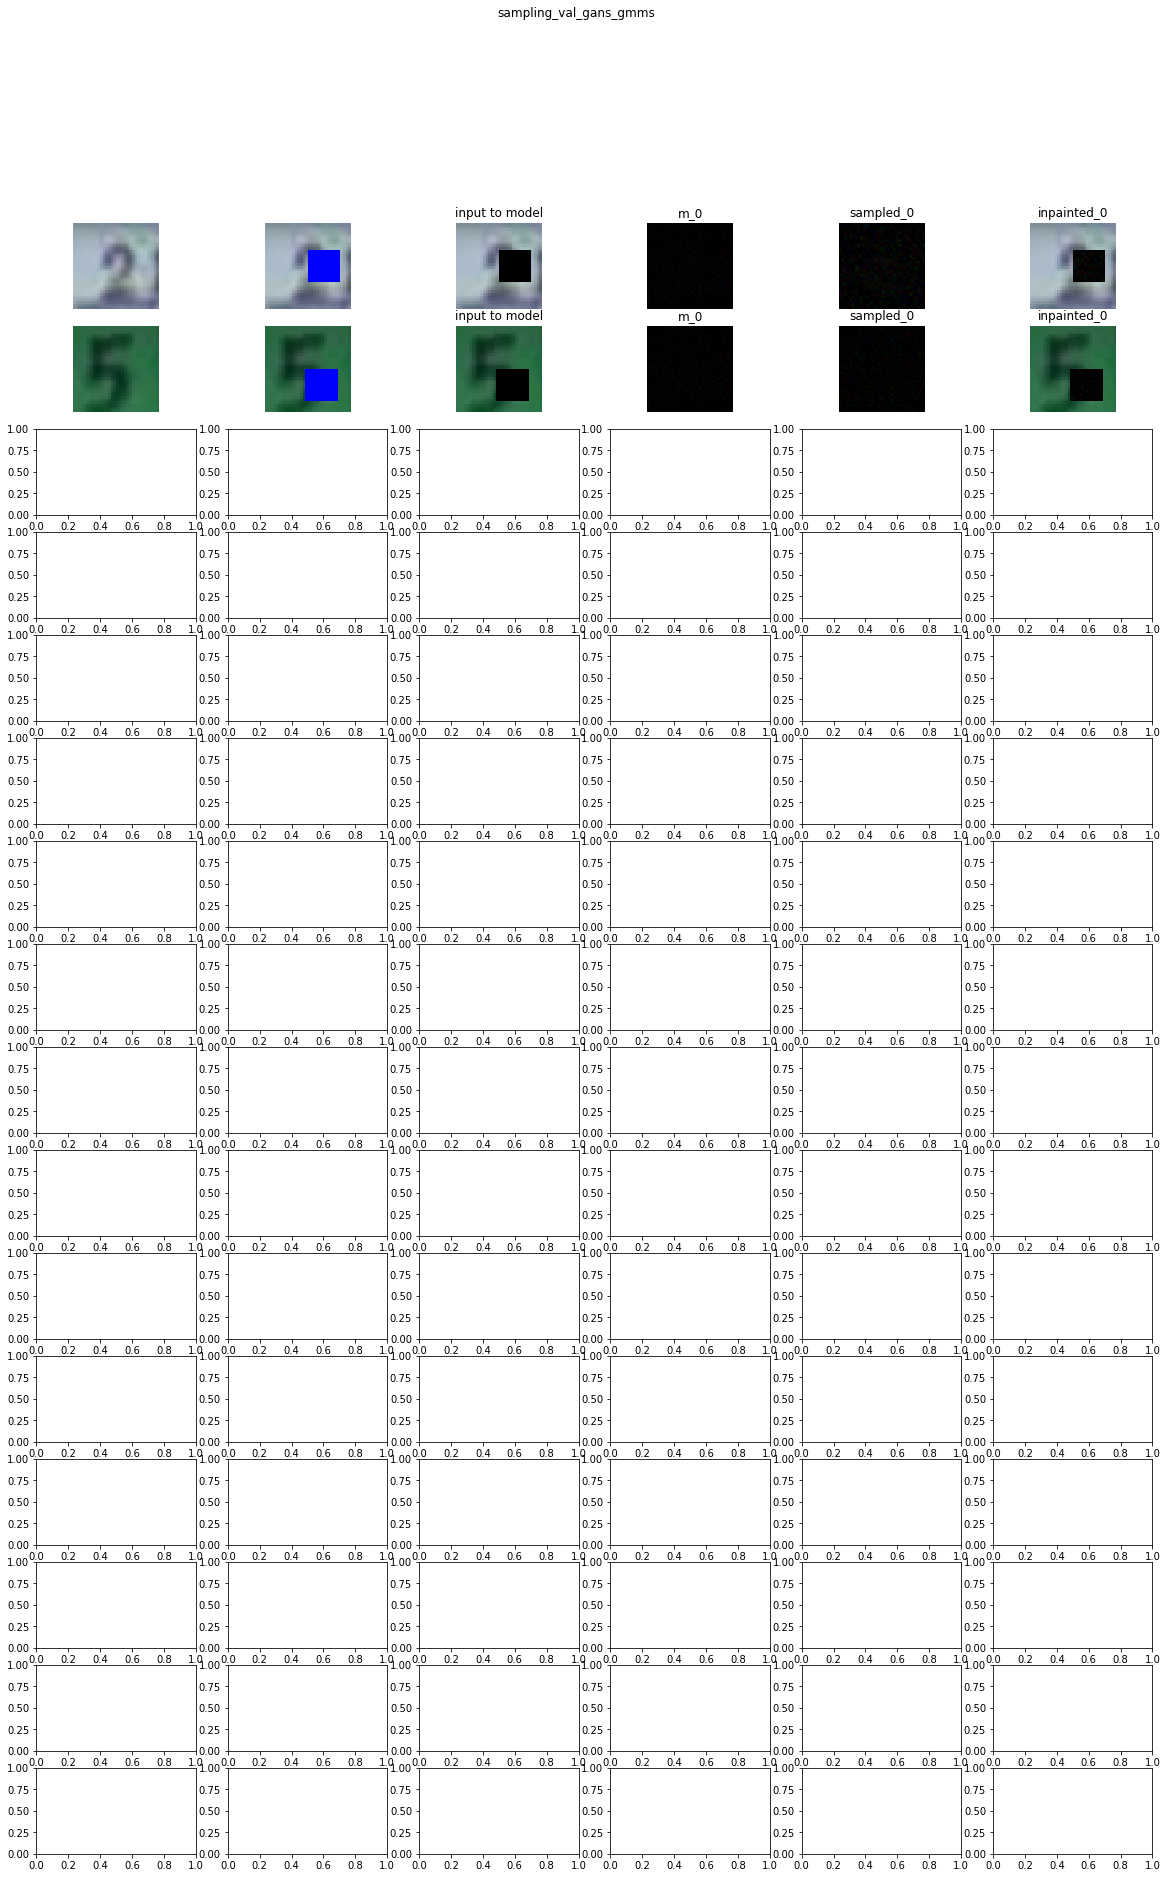

In [87]:
samples_path = experiment_path / "samples"
samples_path.mkdir(exist_ok=True)


samples = history[-1]["sample_results"]

n_rows = 16

for ax_no, fold in [(0,"train"), (1,"val")]:
    
    X, J, P, M, A, D, Y = samples[fold]
    
    for s_name, s_method in [
        ("cov", vis.cov_sample_no_d),
        ("gans_gmms", vis.gans_gmms_sample_no_d)
    ]:
        fig, axes = plt.subplots(
            n_rows, 
            3 + 3 * M.shape[1],
            figsize=(20, 30)
        )

        P_n, M_n, A_n, D_n = P, M, A, D

        for row_no, (x, j, p, m ,a, d, y) in enumerate(list(zip(X, J, P_n, M_n, A_n, D_n, Y))[:n_rows]):
            vis.visualize_distribution_samples(
                x, j, p, m, a, d, y, 
                axes[row_no],
                sample_fn=s_method,
                drawing_fn=rgb_with_mask
            )
        title = f"sampling_{fold}_{s_name}"
        fig.suptitle(title)
        fig.savefig(samples_path / f"{title}.png")
        

In [89]:
import matplotlib.pyplot as plt

def plot_arrays_stats(
    arrays, ax=None, stat_fns = [np.min, np.max, np.mean], markers="."
):
    if ax is None:
        fig, ax = plt.subplots()
        
    if isinstance(markers, str):
        markers = [markers] * len(stat_fns)
    
    for fn, m in zip(stat_fns, markers):
        ax.scatter(
            range(len(arrays)),
            [
                fn(a) for a in arrays
            ],
            marker=m,
            label=fn.__name__
            
        )
    
    return ax

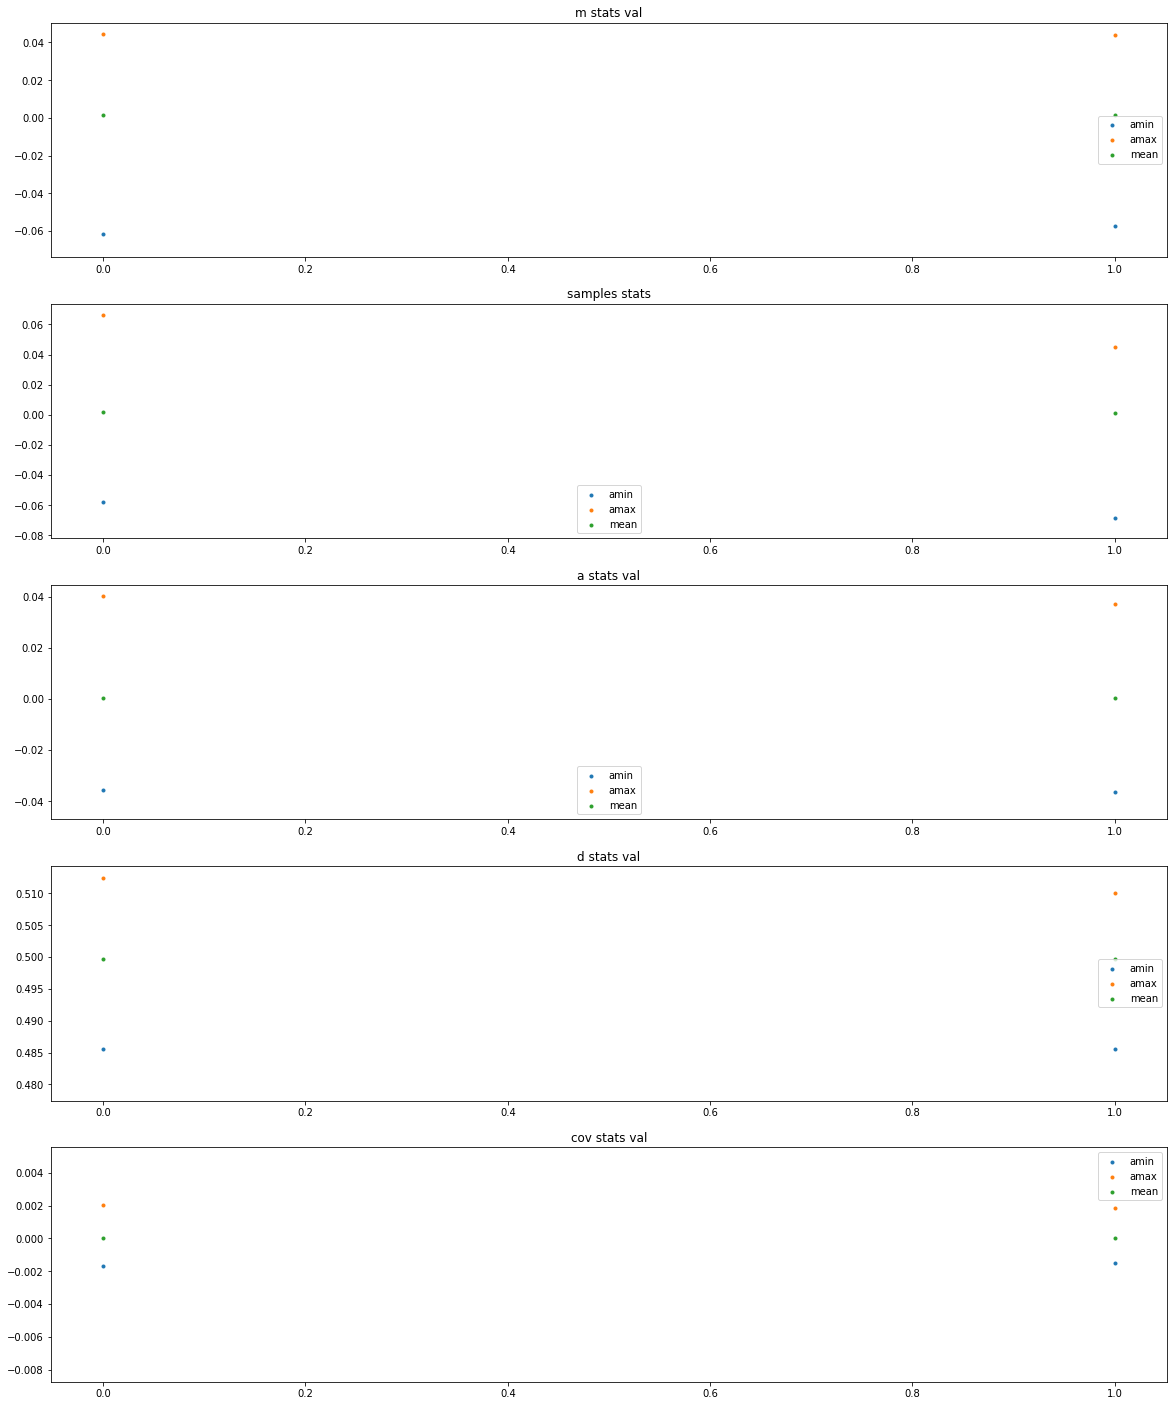

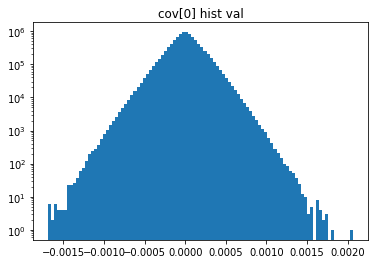

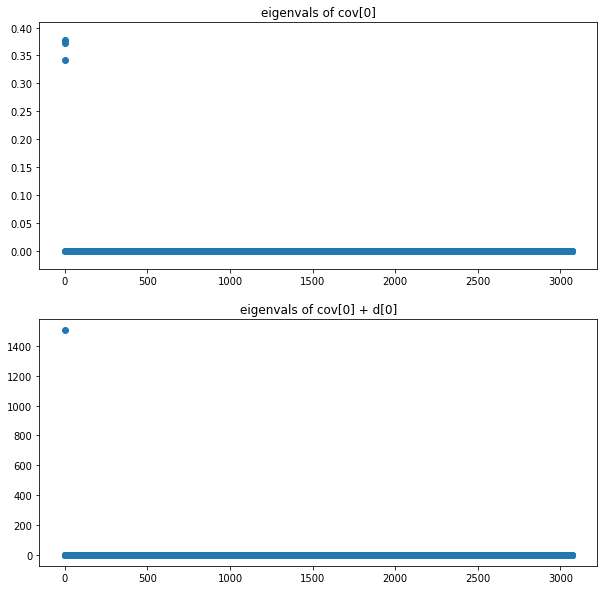

m analysis


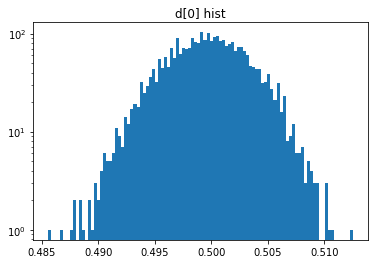

ValueError: cannot reshape array of size 3072 into shape (28,28)

In [90]:
for fold in ["val"]:
    x, j, p, m, a, d, y = hist_last_epoch["sample_results"][fold]

    a_resh = a.reshape(a.shape[0] * a.shape[1], a.shape[2], a.shape[3])
    covs = a_resh.transpose(0, 2, 1) @ a_resh
    
    fig, ax = plt.subplots(figsize=(20, 25), nrows=5)
    
    ax[0].set_title(f"m stats {fold}")
    plot_arrays_stats(
        m, ax[0]
    )
        
    samples = [
        vis.gans_gmms_sample_no_d(x_, m_[0], a_[0], d_[0])
        for (x_, m_, a_, d_) in zip(x, m ,a, d)
    ]
    
    ax[1].set_title("samples stats")
    plot_arrays_stats(samples, ax[1])
    
    ax[2].set_title(f"a stats {fold}")
    plot_arrays_stats(
        a, ax[2]
    )
    
    ax[3].set_title(f"d stats {fold}")
    plot_arrays_stats(
        d, ax[3]
    )
    
    ax[4].set_title(f"cov stats {fold}")
    plot_arrays_stats(
        covs, ax[4]
    )
    [a.legend() for a in ax[:5]]
    fig.savefig(experiment_path / f"outputs_stats.png")
    plt.show()
    
    cov_resh = covs[0].reshape(-1)
    plt.hist(cov_resh, log=True, bins=100)
    plt.title(f"cov[0] hist {fold}")
    plt.show()
    
    cov = covs[0]
    
    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)
    eigs = np.linalg.eigvals(cov)
    ax[0].scatter(range(len(eigs)), eigs)
    ax[0].set_title("eigenvals of cov[0]")

    cov_d = cov + np.diag(d[0])
    eigs_d = np.linalg.eigvals(cov_d)
    ax[1].scatter(range(len(eigs_d)), eigs_d)
    ax[1].set_title("eigenvals of cov[0] + d[0]")
    fig.savefig(experiment_path / "eigenvals.png")
    plt.show()

    # wygląda na to, że mamy ~3 duże wartosci własne
    
    print("m analysis")
    
    
    plt.hist(d[0].reshape(-1), bins=100, log=True)
    plt.title("d[0] hist")
    plt.show()
    
    for i in range(3):
        plt.imshow(a_resh[0, i].reshape(28,28), cmap="gray")
        plt.show()
    
    
    
    